In [1]:
import nltk
nltk.download('nps_chat')

[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Unzipping corpora/nps_chat.zip.


True

In [2]:
from nltk.corpus import nps_chat
from sklearn.model_selection import train_test_split
from tensorflow import keras as k
import tensorflow as tf
import numpy as np
import re

In [3]:
nps_chat.tagged_posts()

[[('now', 'RB'), ('im', 'PRP'), ('left', 'VBD'), ('with', 'IN'), ('this', 'DT'), ('gay', 'JJ'), ('name', 'NN')], [(':P', 'UH')], ...]

In [4]:
def filters(punc=True):
    def inner_filters(x):
        punctuation = r"\^\.|[\.|\`|:|,|\)|\(|\"|\']+"
        condition = [x[0].strip() , x[1].strip()]
        if punc:
            condition.append(not(re.match(punctuation, x[0].strip())))
            condition.append(not(re.match(punctuation, x[1].strip())))
        return  all(condition)

    return inner_filters
    
data = [list(filter(filters(True) , sentence)) for sentence in nps_chat.tagged_posts()]
data = list(filter(lambda vec:len(vec),data)) # remove empty lists

In [5]:
def seq_to_int(data,set_of_words,index_shift=1,padding=True):
    mapper = dict(map(lambda x: x[::-1], enumerate(set_of_words))) # map each word to it's indices

    def word2int(vec):
        if not isinstance(vec[0],list):
            return [mapper[word]+ index_shift if word in mapper.keys() else 1 for word in vec]
        # map each word to an integer, 1 for OOV (out of vocab)
        return list(map(word2int,vec))
        
    mapped_data = list(map(word2int, data))
    if padding:
        mapped_data=k.preprocessing.sequence.pad_sequences(mapped_data, padding= 'post') # pad 2D sentences with 0
    return mapped_data

In [6]:
vocab = [w.lower() for w in nps_chat.words()]
vocab = list(set(vocab)) # create set of words
sentences = [[tup[0].lower() for tup in sentence] for sentence in data] # extract training data from corpus

n= int(len(sentences)/10)
test_data = sentences[:n]
train_word  = sentences[n:]

train_word  = np.array(seq_to_int(train_word ,vocab, index_shift=2, padding=True))
test_data = seq_to_int(test_data, vocab, index_shift=2, padding=False) # no padding for test data

print("train_word",train_word.shape)
print("test_data",len(test_data))

train_word (9430, 72)
test_data 1047


In [7]:
# there is 2 version of this step, look at the bellow cell 
chars = [[list(word) for word in sentence] for sentence in sentences]
char_set = [chr(i) for i in range(32,127)]
chars = seq_to_int(chars, char_set, index_shift=1, padding=False)

# padding 3D ragged list of chars
# shape of padded chars should be: (number_of_sentences, length of padded sentence, maximum length of words)
padded_chars = np.zeros((len(sentences), train_word.shape[1], max(map(len, vocab)))) 

level_len = [[len(word_level) for word_level in sentence_level] for sentence_level in chars] # length of inner list: each word
level_len = k.preprocessing.sequence.pad_sequences(level_len, padding= 'post') # we must also padd length-array
mask = np.arange(padded_chars.shape[-1]) < np.array(level_len)[:, :, None]
padded_chars[mask] = sum(sum(chars, []), [])
train_chars = padded_chars[n:]
test_chars = padded_chars[:n]
print("train_chars",train_chars.shape)

train_chars (9430, 72, 70)


In [ ]:
# different version of above cell. here we cutout each word to have 10 chars at most. and padd the other words to have 10 chars
chars = [[list(word)[:10] for word in sentence] for sentence in sentences] #  we take 10 first chars of each word
char_set = [chr(i) for i in range(32,127)] # charset of ASCI chars
chars = seq_to_int(chars, char_set, index_shift=1, padding=False)

# padding 3D ragged list of chars
# shape of padded chars should be: (number_of_sentences, length of padded sentence, maximum length of words)
padded_chars = np.zeros((len(sentences), train_word.shape[1], 10))

level_len = [[len(word_level) for word_level in sentence_level] for sentence_level in chars] # length of inner list: each word
level_len = k.preprocessing.sequence.pad_sequences(level_len, padding= 'post') # we must also padd length-array
mask = np.arange(padded_chars.shape[-1]) < np.array(level_len)[:, :, None]
padded_chars[mask] = sum(sum(chars, []), [])
train_chars = padded_chars[n:]
test_chars = padded_chars[:n]
print("train_chars",train_chars.shape)

train_chars (9430, 72, 10)


In [8]:
label = [[tup[1] for tup in sentence] for sentence in data] # extract training label from corpus

# Let's see what we have in tags:
tag_set = set(sum(label,[]))
print("number of tags in data:",len(tag_set))
print(" - ".join(tag_set))

# remove "^" character
label = [[word.replace("^","") for word in sentence] for sentence in label]

# replace all punctuation with one label
label = [[re.sub(r"[\.|\`|:|,|\)|\(|\"|\']+","Punctuation",word) for word in sentence] for sentence in label]

tag_set = list(set(sum(label,[])))
print("\nnumber of tags in data after preprocessing:",len(tag_set))
print(" - ".join(tag_set),"\n")

test_label = label[:n]
train_label = label[n:]

train_label = np.array(seq_to_int(train_label,tag_set,index_shift=1,padding=True))
test_label = seq_to_int(test_label,tag_set,index_shift=1,padding=False)

print("train_label",train_label.shape)
print("test_label",len(test_label))

number of tags in data: 64
NNPS - ^VBG - BES - FW - TO - ^PRP^VBP - X - WRB - RBR - ^TO - VB - VBD - NNP - ^UH - LS - RBS - RB - VBG - JJS - ^JJS - VBN - ^RB - ^JJ - IN - ^VB - ^PRP$ - ^NNP - VBZ - MD - UH - ^VBZ - ^VBP - ^VBD - ^CC - SYM - CC - VBP - PRP$ - ^JJR - PDT - ^MD - ^WP - RP - ^NN - ^IN - POS - EX - ^NNS - CD - NNS - NN - WDT - JJ - JJR - ^DT - ^POS - ^WRB - WP - DT - ^VBN - ^RP - GW - ^PRP - PRP

number of tags in data after preprocessing: 39
NNPS - BES - FW - TO - X - WRB - RBR - VB - VBD - NNP - LS - RBS - RB - VBG - JJS - VBN - IN - VBZ - MD - UH - SYM - CC - VBP - PRP$ - PDT - RP - POS - EX - CD - NNS - NN - WDT - JJ - JJR - PRPVBP - WP - DT - GW - PRP 

train_label (9430, 72)
test_label 1047


In [9]:
train_data = [train_word, train_chars]
we_dim = 64
cle_dim = 32
rnn_cell_dim = 64
batch = 100
num_epochs = 10

In [10]:
word_input = k.layers.Input(shape= (train_word.shape[1], ))
word_embedded = k.layers.Embedding(len(vocab)+2, we_dim, input_length=train_word.shape[1], mask_zero=True)(word_input)

char_input = k.layers.Input(shape= (train_chars.shape[1], train_chars.shape[2]))

valid_words = tf.where(word_input!= 0)
CLE = tf.gather_nd(char_input, valid_words)

CLE = k.layers.Embedding(len(char_set)+1, cle_dim, input_length= train_chars.shape[-1], mask_zero=True)(char_input)
CLE = k.layers.Reshape((CLE.shape[1], CLE.shape[2]* CLE.shape[3]))(CLE)
#CLE = k.backend.sum(CLE, axis=-2)

cle_rnn_layer = k.layers.GRU(rnn_cell_dim, return_sequences=True)

CLE = k.layers.Bidirectional(cle_rnn_layer, merge_mode='concat')(CLE)

con_layer = k.layers.concatenate([word_embedded, CLE])
rnn_layer = k.layers.GRU(rnn_cell_dim, return_sequences=True)

rnn_output = k.layers.Bidirectional(rnn_layer, merge_mode='sum')(con_layer)

predictions = k.layers.Dense(len(tag_set)+1, activation='softmax')(rnn_output)

model = k.Model(inputs=[word_input,char_input], outputs=predictions)

print(model.summary())


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 70)]     0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 72, 70, 32)   3072        input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 72)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 72, 2240)     0           embedding_1[0][0]                
_______________________________________________________________________________________

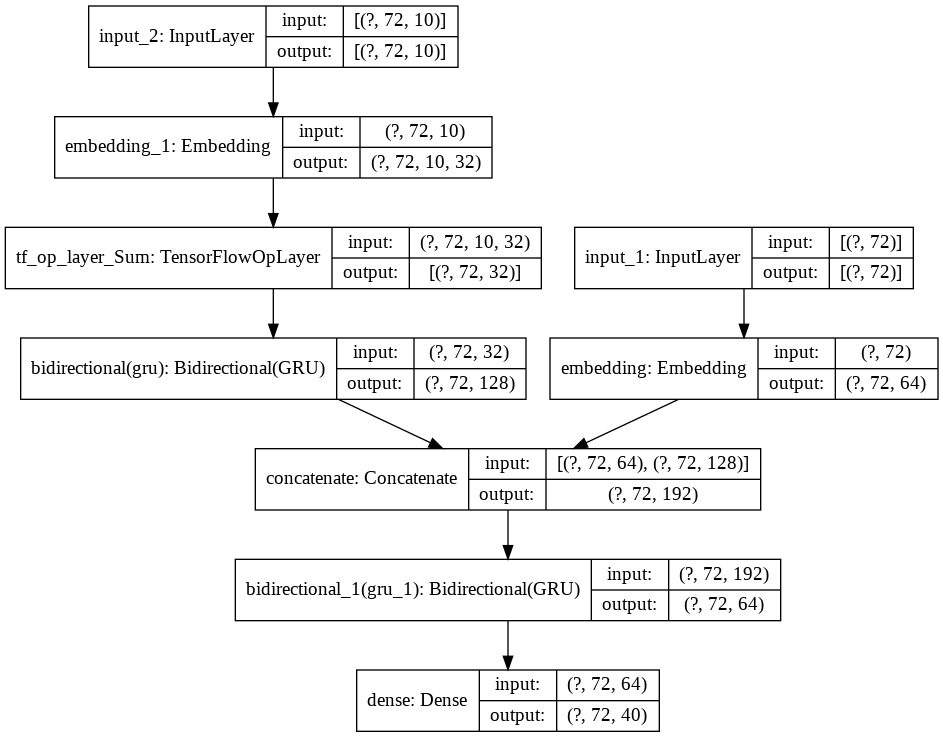

In [ ]:
k.utils.plot_model(model, show_shapes=True)

In [11]:
model.compile(optimizer=k.optimizers.Adam(),
                           loss=k.losses.SparseCategoricalCrossentropy(),
                           metrics=[k.metrics.SparseCategoricalAccuracy(name='accuracy')])

model.fit(x=train_data,y=train_label, batch_size=batch, epochs=num_epochs, validation_split=0.1)

Epoch 1/10
85/85 [==============================] - 127s 1s/step - loss: 0.1298 - accuracy: 0.3535 - val_loss: 0.0718 - val_accuracy: 0.6037
Epoch 2/10
85/85 [==============================] - 126s 1s/step - loss: 0.0507 - accuracy: 0.7644 - val_loss: 0.0288 - val_accuracy: 0.8493
Epoch 3/10
85/85 [==============================] - 127s 1s/step - loss: 0.0239 - accuracy: 0.8955 - val_loss: 0.0204 - val_accuracy: 0.8864
Epoch 4/10
85/85 [==============================] - 131s 2s/step - loss: 0.0152 - accuracy: 0.9331 - val_loss: 0.0177 - val_accuracy: 0.8984
Epoch 5/10
85/85 [==============================] - 127s 1s/step - loss: 0.0110 - accuracy: 0.9495 - val_loss: 0.0172 - val_accuracy: 0.8978
Epoch 6/10
85/85 [==============================] - 127s 1s/step - loss: 0.0089 - accuracy: 0.9562 - val_loss: 0.0169 - val_accuracy: 0.9009
Epoch 7/10
85/85 [==============================] - 127s 1s/step - loss: 0.0075 - accuracy: 0.9617 - val_loss: 0.0164 - val_accuracy: 0.9035
Epoch 8/10
85

In [12]:
eval_data = k.preprocessing.sequence.pad_sequences(test_data,padding='post',maxlen=72)
eval_label = k.preprocessing.sequence.pad_sequences(test_label,padding='post', maxlen=72)
model.evaluate(x=[eval_data,test_chars],y=eval_label)

33/33 [==============================] - 5s 137ms/step - loss: 0.0204 - accuracy: 0.8901


[0.020410161465406418, 0.890073835849762]

In [ ]:
prediction = model.predict([eval_data, test_chars])
prediction = np.argmax(prediction, axis=-1)
prediction = [p[0][:p[1]].tolist() for p in zip(prediction, map(len, test_data))]
from sklearn import metrics

y_true = sum(test_label,[])
y_pred = sum(prediction,[])

#print(metrics.confusion_matrix(y_true, y_pred)
print(metrics.classification_report(y_true,y_pred, labels=range(len(tag_set)+1), target_names=tag_set))